# Getting started with computer vision

## How convolutional neural networks work

A summary from: https://lightning.ai/courses/deep-learning-fundamentals/unit-7-overview-getting-started-with-computer-vision/

**Local Feature Extraction**
- CNNs use **learnable filters** to extract local features from input data through **convolution**. The convolution operation involves sliding the filters over the input data, element-wise multiplying the filter values with overlapping input values and summing the results. The result is a **feature map** that represents the response of a fliter to a specific input region. The learned features do not change per location in the input data, but are shared across the entire input. This is called **parameter sharing** and it reduces the number of parameters in the network.

CNNs are often organized into layers, where each layer captures increasingly abstract and high-level features. Early layers tend to learn simple features like edges, corners, and textures, while deeper layers capture complex patterns and object parts.

 Convolution layers typically mdodify the number of channels as follows:

<div style="text-align:center;">
    <img src="cnn_chans.png" width="800">
</div>

**Pooling**
While convolutions increase the number of channels, pooling layers reduce the spatial dimension of the feature maps while retaining the most important information.

The size of output feature maps is determined by the following formula:

$$
\frac{W - F + 2P}{S} + 1
$$

where $W$ is the input size, $F$ is the filter size, $P$ is the padding and $S$ is the stride.
For instance if we have a $32 \times 32$ input, a $5 \times 5$ filter, no padding and a stride of 1, the output size will be $28 \times 28$.

**Inductive biases** in a CNN are inherent assumptions or prior knowledge that the architecture and design of CNN impose on the learning. Key biases include:
- **Translation invariance**: the learned features are not affected by the location of the object in the input data.
- **Parameter sharing**: the same filter is applied to multiple locations in the input data.
- **Sparse connectivity**: Neighbouring pixels are related

## Training a resnet model frim torchvision hub

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import random_split
from torchvision import datasets, transforms
import lightning as L
import torchmetrics
from sklearn.datasets import make_classification
import numpy as np
from sklearn.model_selection import train_test_split
from lightning.pytorch.loggers import CSVLogger
import matplotlib.pyplot as plt

entrypoints = torch.hub.list("pytorch/vision", force_reload = True)

# Print entry points for resnet
for entry in entrypoints:
    if "resnet" in entry:
        print(entry)

c:\Users\homeuser\Documents\deep_learning_fundamentals\dlf\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")
Downloading: "https://github.com/pytorch/vision/zipball/main" to C:\Users\homeuser/.cache\torch\hub\main.zip


deeplabv3_resnet101
deeplabv3_resnet50
fcn_resnet101
fcn_resnet50
resnet101
resnet152
resnet18
resnet34
resnet50
wide_resnet101_2
wide_resnet50_2


## Exploring the CIFAR10 dataset

Files already downloaded and verified


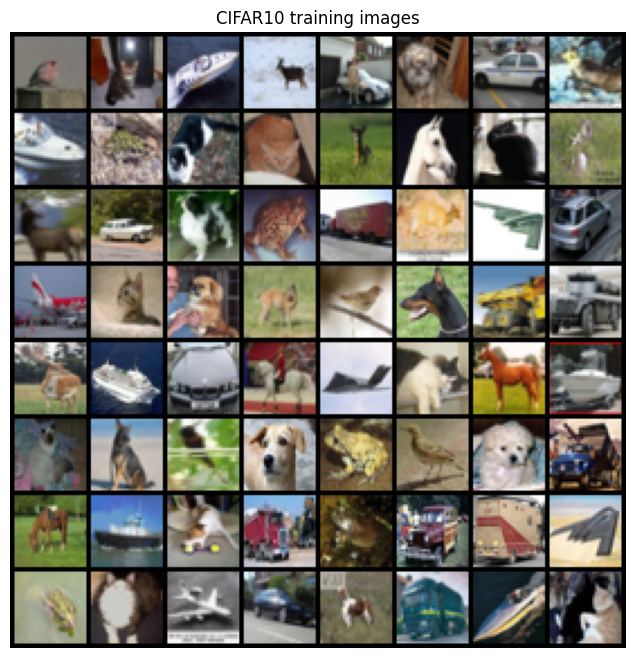

In [40]:
from shared_utilities import Cifar10DataModule
dm = Cifar10DataModule(batch_size = 64)
dm.prepare_data()
dm.setup(stage = "train")
train_dl = dm.train_dataloader()
val_dl = dm.val_dataloader()
test_dl = dm.test_dataloader()
import torchvision
# Visualize a batch of images
for images, labels in train_dl:
    break

plt.figure(figsize=(8,8))
plt.title("CIFAR10 training images")
plt.axis('off')
plt.imshow(torchvision.utils.make_grid(
    images[:64],
    padding = 2,
    normalize = True
).permute(1, 2, 0))

In [22]:
# Count number of classes using Counter
from collections import Counter

train_counter = Counter()
for _, labels in train_dl:
    train_counter.update(sorted(labels.tolist()))
# Sort the counter by key
print(f"Train labels: {sorted(train_counter.items())}")

val_counter = Counter()
for _, labels in val_dl:
    val_counter.update(sorted(labels.tolist()))
# Sort the counter by key
print(f"Validation labels: {sorted(val_counter.items())}")

test_counter = Counter()
for _, labels in test_dl:
    test_counter.update(sorted(labels.tolist()))
# Sort the counter by key   
print(f"Test labels: {sorted(test_counter.items())}")


Train labels: [(0, 4540), (1, 4524), (2, 4473), (3, 4477), (4, 4513), (5, 4494), (6, 4493), (7, 4490), (8, 4511), (9, 4485)]
Validation labels: [(0, 460), (1, 476), (2, 527), (3, 523), (4, 487), (5, 506), (6, 507), (7, 510), (8, 489), (9, 515)]
Test labels: [(0, 1000), (1, 1000), (2, 1000), (3, 1000), (4, 1000), (5, 1000), (6, 1000), (7, 1000), (8, 1000), (9, 1000)]


Well balanced!!

In [33]:
# Implement majority class baseline
most_common_class = test_counter.most_common(1)[0]
print(f"Most common class: {most_common_class[0]}")

majority_class_accuracy = most_common_class[1] / sum(test_counter.values())
print(f"Baseline class accuracy: {majority_class_accuracy*100:.2f}%")

Most common class: 0
Baseline class accuracy: 10.00%


## Training a ResNet to classify images

In [37]:
from lightning.pytorch.callbacks import ModelCheckpoint
from shared_utilities import LightningModel, Cifar10DataModule 
num_epochs = 20
# Load resnet 18
pytorch_model = torch.hub.load("pytorch/vision", "resnet18", weights = None)
# Change the last layer to have 10 outputs
pytorch_model.fc = nn.Linear(512, 10)


# Instantiate a lightning model
lightning_model = LightningModel(pytorch_model = pytorch_model, learning_rate = 0.1, cosine_steps = num_epochs)

# Instantiate data module
dm = Cifar10DataModule(batch_size = 64, num_workers=2)

callbacks = [ModelCheckpoint(monitor="val_acc", save_top_k=1, mode = "max")]

# Set up trainer
trainer = L.Trainer(
    max_epochs = num_epochs,
    accelerator = "auto",
    devices = "auto",
    logger = CSVLogger("logs", name = "resnet18"),
    callbacks = callbacks

)

# Train the model
trainer.fit(model = lightning_model, datamodule=dm)

# Perform inference on the test set
path = trainer.checkpoint_callback.best_model_path
trainer.test(model = lightning_model, dataloaders = dm.test_dataloader(), ckpt_path = path)


Using cache found in C:\Users\homeuser/.cache\torch\hub\pytorch_vision_main
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Files already downloaded and verified


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | ResNet             | 11.2 M
1 | train_acc | MulticlassAccuracy | 0     
2 | val_acc   | MulticlassAccuracy | 0     
3 | test_acc  | MulticlassAccuracy | 0     
-------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

c:\Users\homeuser\Documents\deep_learning_fundamentals\dlf\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\homeuser\Documents\deep_learning_fundamentals\dlf\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


Files already downloaded and verified


Restoring states from the checkpoint path at logs\resnet18\version_0\checkpoints\epoch=17-step=12672.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at logs\resnet18\version_0\checkpoints\epoch=17-step=12672.ckpt
c:\Users\homeuser\Documents\deep_learning_fundamentals\dlf\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:442: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┌───────────────────────────┬───────────────────────────┐
│        Test metric        │       DataLoader 0        │
├───────────────────────────┼───────────────────────────┤
│         test_acc          │    0.7511000037193298     │
└───────────────────────────┴───────────────────────────┘


[{'test_acc': 0.7511000037193298}]

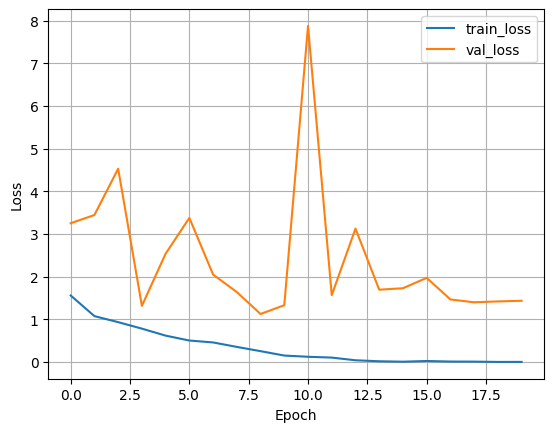

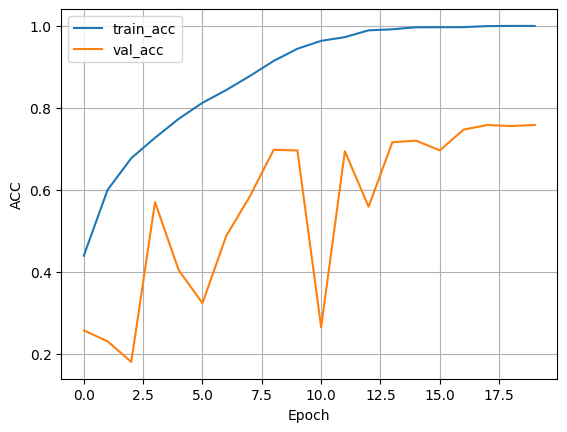

In [38]:
# Plot the training and validation loss
from matplotlib import pyplot as plt
import pandas as pd
def plot_csv_logger(
    csv_path, loss_names=["train_loss", "val_loss"], eval_names=["train_acc", "val_acc"]
):

    metrics = pd.read_csv(csv_path)

    aggreg_metrics = []
    agg_col = "epoch"
    for i, dfg in metrics.groupby(agg_col):
        agg = dict(dfg.mean())
        agg[agg_col] = i
        aggreg_metrics.append(agg)

    df_metrics = pd.DataFrame(aggreg_metrics)
    df_metrics[loss_names].plot(grid=True, legend=True, xlabel="Epoch", ylabel="Loss")
    df_metrics[eval_names].plot(grid=True, legend=True, xlabel="Epoch", ylabel="ACC")

    plt.show()

plot_csv_logger(csv_path= f"{trainer.logger.log_dir}/metrics.csv")
# trainer.logger.log_dir points to the directory where the logger saves the LATEST metrics.csv file

## Data augmentation

Data augmentation is a technique used during training to artificially increase the diversity of the training set by applying random transformations to the training images, such as flips, rotations, crops, and color jittering. This makes the model learning more robust and prevents overfitting.

Files already downloaded and verified


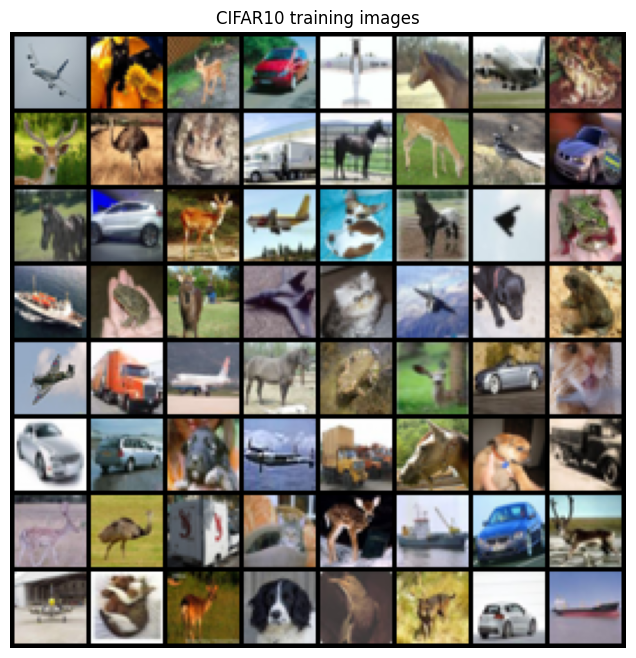

In [43]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(size = (224, 224)),
    transforms.RandomCrop(size = (128, 128)), # Randomly crop to 128 x 128
    transforms.RandomHorizontalFlip(p = 0.2),
    transforms.ColorJitter(brightness = 0.1, contrast = 0.1, saturation = 0.1, hue = 0.1),
    transforms.ToTensor(), # Converts to [0, 1]
    transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5]), # Converts to [-1, 1]

])

test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(size = (224, 224)),
    transforms.CenterCrop(size = (128, 128)), # Deterministically crop to 128 x 128
    transforms.ToTensor(), # Converts to [0, 1]
    transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5]), # Converts to [-1, 1]
])

# Let's see how the transforms look like
torch.manual_seed(2056)
dm = Cifar10DataModule(batch_size = 64)
dm.prepare_data()
dm.setup(stage = "train")
train_dl = dm.train_dataloader()

for images, labels in train_dl:
    break

plt.figure(figsize = (8, 8))
plt.axis("off")
plt.title("CIFAR10 training images")
plt.imshow(torchvision.utils.make_grid(
    images[:64],
    padding = 2,
    normalize = True
).permute(1, 2, 0));


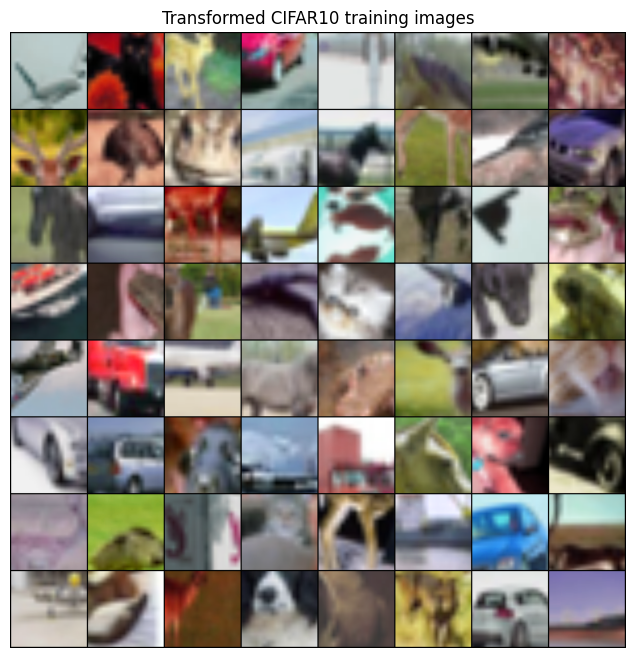

In [44]:
transformed_images = [train_transform(i) for i in images]
plt.figure(figsize = (8, 8))
plt.axis("off")
plt.title("Transformed CIFAR10 training images")
plt.imshow(torchvision.utils.make_grid(
    transformed_images[:64],
    padding = 2,
    normalize = True
).permute(1, 2, 0));


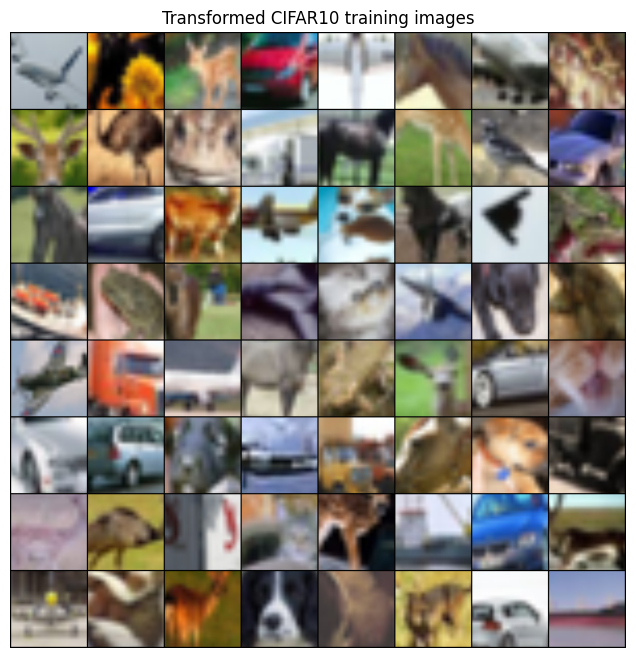

In [45]:
transformed_images = [test_transform(i) for i in images]
plt.figure(figsize = (8, 8))
plt.axis("off")
plt.title("Transformed CIFAR10 training images")
plt.imshow(torchvision.utils.make_grid(
    transformed_images[:64],
    padding = 2,
    normalize = True
).permute(1, 2, 0));

## Train ResNet using data augmentations

Now let's use data augmentation.

In [2]:
from torchvision import transforms

train_transform = transforms.Compose([
    #transforms.ToPILImage(),
    transforms.Resize(size = (224, 224)),
    transforms.RandomCrop(size = (128, 128)), # Randomly crop to 128 x 128
    transforms.RandomHorizontalFlip(p = 0.2),
    transforms.ColorJitter(brightness = 0.1, contrast = 0.1, saturation = 0.1, hue = 0.1),
    transforms.ToTensor(), # Converts to [0, 1]
    transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5]), # Converts to [-1, 1]

])

test_transform = transforms.Compose([
   # transforms.ToPILImage(),
    transforms.Resize(size = (224, 224)),
    transforms.CenterCrop(size = (128, 128)), # Deterministically crop to 128 x 128
    transforms.ToTensor(), # Converts to [0, 1]
    transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5]), # Converts to [-1, 1]
])

# Create a lightning data module: training/validation/test data datasets and data loaders
class Cifar10DataModule(L.LightningDataModule):
    def __init__(self, data_path = "./", batch_size = 64, num_workers = 0, height_width = (32, 32), train_transform = None, test_transform = None):
        super().__init__()
        self.data_path = data_path
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.height_width = height_width
        self.train_transform = train_transform
        self.test_transform = test_transform

    def prepare_data(self): # Processes that will be done on 1 GPU e.g. download
        datasets.CIFAR10(root = self.data_path, download = True)

        # # Transformations
        # self.train_transform = transforms.Compose([
        #     transforms.Resize(size = self.height_width),
        #     transforms.ToTensor(), # Converts to [0, 1]
        # ])

        # self.test_transform = transforms.Compose([
        #     transforms.Resize(size = self.height_width),
        #     transforms.ToTensor(), # Converts to [0, 1]
        # ])
        return
    
    def setup(self, stage = None): # Processes that will be done on every GPU e.g. train/val/test split
        # Test dataset
        self.test_dataset = datasets.CIFAR10(
            root = self.data_path,
            train = False,
            transform = self.test_transform,
            download = False
        )

        # Train/val datasets
        train = datasets.CIFAR10(
            root = self.data_path,
            train = True,
            transform = self.train_transform,
            download = False
        )
        self.train_dataset, self.val_dataset = random_split(
            dataset = train,
            lengths = [45000, 5000])
        
        # self.train_dataset.dataset.transform = self.train_transform
        # self.val_dataset.dataset.transform = self.test_transform
        
    # Train data loader
    def train_dataloader(self):
        train_dl = DataLoader(
            dataset = self.train_dataset,
            batch_size = self.batch_size,
            num_workers = self.num_workers,
            shuffle = True

        )
        return train_dl
    
    # Validation data loader
    def val_dataloader(self):
        val_dl = DataLoader(
            dataset = self.val_dataset,
            batch_size = self.batch_size,
            num_workers = self.num_workers,
            shuffle = False

        )
        return val_dl
    
    # Test data loader
    def test_dataloader(self):
        test_dl = DataLoader(
            dataset = self.test_dataset,
            batch_size = self.batch_size,
            num_workers = self.num_workers,
            shuffle = False

        )
        return test_dl

    
# Instantiate data module
dm = Cifar10DataModule(batch_size = 64, num_workers=2, train_transform = train_transform, test_transform = test_transform)

from lightning.pytorch.callbacks import ModelCheckpoint
from shared_utilities import LightningModel
num_epochs = 50
# Load resnet 18
pytorch_model = torch.hub.load("pytorch/vision", "resnet18", weights = None)
# Change the last layer to have 10 outputs
pytorch_model.fc = nn.Linear(512, 10)


# Instantiate a lightning model
lightning_model = LightningModel(pytorch_model = pytorch_model, learning_rate = 0.1, cosine_steps = num_epochs)

callbacks = [ModelCheckpoint(monitor="val_acc", save_top_k=1, mode = "max")]

# Set up trainer
trainer = L.Trainer(
    max_epochs = num_epochs,
    accelerator = "auto",
    devices = "auto",
    logger = CSVLogger("logs", name = "resnet18"),
    callbacks = callbacks

)

# Train the model
trainer.fit(model = lightning_model, datamodule=dm)

# Perform inference on the test set
path = trainer.checkpoint_callback.best_model_path
print(path)
trainer.test(model = lightning_model, dataloaders = dm.test_dataloader(), ckpt_path = path)



Using cache found in C:\Users\homeuser/.cache\torch\hub\pytorch_vision_main
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Files already downloaded and verified


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | ResNet             | 11.2 M
1 | train_acc | MulticlassAccuracy | 0     
2 | val_acc   | MulticlassAccuracy | 0     
3 | test_acc  | MulticlassAccuracy | 0     
-------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

c:\Users\homeuser\Documents\deep_learning_fundamentals\dlf\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\homeuser\Documents\deep_learning_fundamentals\dlf\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


logs\resnet18\version_2\checkpoints\epoch=45-step=32384.ckpt
Files already downloaded and verified


Restoring states from the checkpoint path at logs\resnet18\version_2\checkpoints\epoch=45-step=32384.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at logs\resnet18\version_2\checkpoints\epoch=45-step=32384.ckpt
c:\Users\homeuser\Documents\deep_learning_fundamentals\dlf\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:442: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8671000003814697     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.8671000003814697}]

## Leveraging pretrained models with transfer learning

Transfer learning is a machine learning technique that involves leveraging knowledge learned from one task or domian to improve performance on a different, but related task. In transfer learning, models start with pre-trained knowledge obtained from large datasets where they learn useful features. These models are then adapted (or fine-tuned) on a smaller dataset where the model adjusts its internal representations to align with the new task.

Ways of using transfer learning:

1. Fine-tune last layer: The simplest and most common approach is to replace the last layer of the pre-trained model with an output layer that matches the number of classes in the new dataset. During training, we only backpropagate (i.e. compute gradients and update model parameters) through the randomly initialized weights in the new layers and keep the pre-trained weights frozen. This is called fine-tuning because we are only updating the layer of the model.

2. Fine-tuning last layers: This involves replacing the last layer with a layer that matches the number of classes in the new dataset, freezing the rest of the model and training the fully connected layers + new layer.

3. Fine-tuning entire model: This involves replacing the last layer with a layer that matches the number of classes in the new dataset, and training the entire model (i.e. all layers) with a very low learning rate.

In this notebook, we'll change the last layer and tune the whole model.

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import random_split
from torchvision import datasets, transforms
import lightning as L
import torchmetrics
from sklearn.datasets import make_classification
import numpy as np
from sklearn.model_selection import train_test_split
from lightning.pytorch.loggers import CSVLogger
import matplotlib.pyplot as plt

# Load a pretrained resnet-18 model
pytorch_model = torch.hub.load("pytorch/vision", "resnet18", weights = "IMAGENET1K_V1")
pytorch_model

Using cache found in C:\Users\homeuser/.cache\torch\hub\pytorch_vision_main


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Now,let's replace the last layer of the pretrained model with a new fully connected layer that outputs 10 classes.

In [5]:
# # How to freeze the weights of the entire model
# for param in pytorch_model.parameters():
#     param.requires_grad = False

# Modify the last layer to have a linear trainable layer with 10 outputs
pytorch_model.fc = nn.Linear(in_features = 512, out_features = 10, bias = True)


For data augmentation, we'll use the augmentations used during pretraining of the larger ResNet model on ImageNet.

In [6]:
from torchvision.models import resnet18, ResNet18_Weights
weights = ResNet18_Weights.IMAGENET1K_V1
preprocess_transform = weights.transforms()
preprocess_transform

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [7]:
# Create a lightning data module: training/validation/test data datasets and data loaders
class Cifar10DataModule(L.LightningDataModule):
    def __init__(self, data_path = "./", batch_size = 64, num_workers = 0, height_width = (32, 32), train_transform = None, test_transform = None):
        super().__init__()
        self.data_path = data_path
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.height_width = height_width
        self.train_transform = train_transform
        self.test_transform = test_transform

    def prepare_data(self): # Processes that will be done on 1 GPU e.g. download
        datasets.CIFAR10(root = self.data_path, download = True)

        # # Transformations
        # self.train_transform = transforms.Compose([
        #     transforms.Resize(size = self.height_width),
        #     transforms.ToTensor(), # Converts to [0, 1]
        # ])

        # self.test_transform = transforms.Compose([
        #     transforms.Resize(size = self.height_width),
        #     transforms.ToTensor(), # Converts to [0, 1]
        # ])
        return
    
    def setup(self, stage = None): # Processes that will be done on every GPU e.g. train/val/test split
        # Test dataset
        self.test_dataset = datasets.CIFAR10(
            root = self.data_path,
            train = False,
            transform = self.test_transform,
            download = False
        )

        # Train/val datasets
        train = datasets.CIFAR10(
            root = self.data_path,
            train = True,
            transform = self.train_transform,
            download = False
        )
        self.train_dataset, self.val_dataset = random_split(
            dataset = train,
            lengths = [45000, 5000])
        
        # self.train_dataset.dataset.transform = self.train_transform
        # self.val_dataset.dataset.transform = self.test_transform
        
    # Train data loader
    def train_dataloader(self):
        train_dl = DataLoader(
            dataset = self.train_dataset,
            batch_size = self.batch_size,
            num_workers = self.num_workers,
            shuffle = True

        )
        return train_dl
    
    # Validation data loader
    def val_dataloader(self):
        val_dl = DataLoader(
            dataset = self.val_dataset,
            batch_size = self.batch_size,
            num_workers = self.num_workers,
            shuffle = False

        )
        return val_dl
    
    # Test data loader
    def test_dataloader(self):
        test_dl = DataLoader(
            dataset = self.test_dataset,
            batch_size = self.batch_size,
            num_workers = self.num_workers,
            shuffle = False

        )
        return test_dl


# Instantiate data module with the preprocess_transform used in the pretrained model
dm = Cifar10DataModule(
    batch_size = 64,
    num_workers = 2,
    train_transform = preprocess_transform,
    test_transform = preprocess_transform
)


from lightning.pytorch.callbacks import ModelCheckpoint
from shared_utilities import LightningModel
num_epochs = 50
lightning_model = LightningModel(pytorch_model = pytorch_model, learning_rate = 0.1, cosine_steps = num_epochs)

callbacks = [ModelCheckpoint(monitor="val_acc", save_top_k=1, mode = "max")]

# Set up trainer
trainer = L.Trainer(
    max_epochs = num_epochs,
    accelerator = "auto",
    devices = "auto",
    logger = CSVLogger("logs", name = "resnet18_ft"),
    callbacks = callbacks,
    precision=16

)

# Fine tune the entire model
trainer.fit(model = lightning_model, datamodule=dm)



Perform inference on test set

In [ ]:
from pathlib import Path
from shared_utilities import LightningModel
path = Path("logs\\resnet18_ft\\version_1\\checkpoints\\epoch=17-step=12672.ckpt")
# Load a pretrained resnet-18 model
pytorch_model = torch.hub.load("pytorch/vision", "resnet18", weights = "IMAGENET1K_V1")
pytorch_model.fc = nn.Linear(in_features = 512, out_features = 10, bias = True)

# Load lightning model from checkpoint
lightning_model = LightningModel.load_from_checkpoint(checkpoint_path=path, pytorch_model=pytorch_model)

# Put model in eval mode
lightning_model = lightning_model.eval()

`lightning_model = lightning_model.eval()` - Not necessary but good practice since Lightning disables gradients, puts model in eval mode, and does everything needed for testing.

In [18]:

num_epochs = 50
from lightning.pytorch.callbacks import ModelCheckpoint
callbacks = [ModelCheckpoint(monitor="val_acc", save_top_k=1, mode = "max")]

# Set up trainer
trainer = L.Trainer(
    max_epochs = num_epochs,
    accelerator = "auto",
    devices = "auto",
    logger = CSVLogger("logs", name = "resnet18"),
    callbacks = callbacks

)

dm = Cifar10DataModule(
    batch_size = 64,
    num_workers = 2,
    train_transform = preprocess_transform,
    test_transform = preprocess_transform
)

dm.setup(stage = "test")
trainer.test(model = lightning_model, dataloaders = dm.test_dataloader(), ckpt_path = path)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs
Restoring states from the checkpoint path at logs\resnet18_ft\version_1\checkpoints\epoch=17-step=12672.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at logs\resnet18_ft\version_1\checkpoints\epoch=17-step=12672.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9498999714851379     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.9498999714851379}]

In [23]:
# Alternative way to calculate metrics
from pathlib import Path
from shared_utilities import LightningModel
path = Path("logs\\resnet18_ft\\version_1\\checkpoints\\epoch=17-step=12672.ckpt")
# Load a pretrained resnet-18 model
pytorch_model = torch.hub.load("pytorch/vision", "resnet18", weights = "IMAGENET1K_V1")
pytorch_model.fc = nn.Linear(in_features = 512, out_features = 10, bias = True)

from torchvision.models import resnet18, ResNet18_Weights
weights = ResNet18_Weights.IMAGENET1K_V1
preprocess_transform = weights.transforms()


# Load lightning model from checkpoint
lightning_model = LightningModel.load_from_checkpoint(checkpoint_path=path, pytorch_model=pytorch_model)

# Put model in eval mode
lightning_mode = pytorch_model.eval()

# Load data module and extract test data loader
dm = Cifar10DataModule(
    batch_size = 64,
    num_workers = 2,
    train_transform = preprocess_transform,
    test_transform = preprocess_transform
)
dm.setup(stage = "test")
test_dl = dm.test_dataloader()

# Ensure everything is on the same device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
acc = torchmetrics.Accuracy(task = "multiclass", num_classes = 10).to(device)

# Calculate accuracy
with torch.inference_mode(): # Turn off gradient calculation
    for batch in test_dl:
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)
        logits = lightning_model(images)
        preds = torch.argmax(logits, dim = 1)
        acc.update(preds, labels)

# Test accuracy
test_acc = acc.compute()
print(f"Test accuracy: {test_acc*100:.4f}%")


Using cache found in C:\Users\homeuser/.cache\torch\hub\pytorch_vision_main


Test accuracy: 94.9900%


In [ ]:
%%writefile shared_utilities.py

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import random_split
from torchvision import datasets, transforms
import lightning as L
import torchmetrics
from sklearn.datasets import make_classification
import numpy as np
from sklearn.model_selection import train_test_split
from lightning.pytorch.loggers import CSVLogger
import matplotlib.pyplot as plt

# Create a lightning model: pytorch model, training/validation/test loops, optimizer, learning rate scheduler, metrics
class LightningModel(L.LightningModule):

    def __init__(self, pytorch_model, learning_rate, cosine_steps):
        super().__init__()
        self.model = pytorch_model
        self.learning_rate = learning_rate
        self.cosine_steps = cosine_steps

        # Save hypeprparameters
        self.save_hyperparameters(ignore=["pytorch_model"])

        # Define metrics
        self.train_acc = torchmetrics.Accuracy(task = "multiclass", num_classes = 10)
        self.val_acc = torchmetrics.Accuracy(task = "multiclass", num_classes = 10)
        self.test_acc = torchmetrics.Accuracy(task = "multiclass", num_classes = 10)

    def forward(self, x):
        # Use forward for inference/predictions
        return self.model(x)
    
    def _shared_step(self, batch):
        features, true_labels = batch
        logits = self(features)
        loss = F.cross_entropy(logits, true_labels)

        predicted_labels = torch.argmax(logits, dim = 1)
        return loss, predicted_labels, true_labels
    
    # Training step/loop
    def training_step(self, batch, batch_idx):
        loss, predicted_labels, true_labels = self._shared_step(batch)
        self.log("train_loss", loss, prog_bar=True)

        self.train_acc(predicted_labels, true_labels)
        self.log("train_acc", self.train_acc, prog_bar = True, on_step = False, on_epoch = True)
        return loss # return loss for optimizer
    
    # Validation step/loop
    def validation_step(self, batch, batch_idx):
        loss, predicted_labels, true_labels = self._shared_step(batch)
        self.log("val_loss", loss, prog_bar = True)
        self.val_acc(predicted_labels, true_labels)
        self.log("val_acc", self.val_acc, prog_bar = True)

    # Test step/loop
    def test_step(self, batch, batch_idx):
        loss, predicted_labels, true_labels = self._shared_step(batch)
        self.test_acc(predicted_labels, true_labels)
        self.log("test_acc", self.test_acc)

    # Configure optimizer and learning rate scheduler
    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr = self.learning_rate)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=self.cosine_steps)
        return {
            "optimizer": optimizer,
            "lr_scheduler":{
                "scheduler": scheduler,
                "monitor": "train_loss",
                "interval": "epoch",
                "frequency": 1
            }
        }

